In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer # fazer a transformação de colunas
from sklearn.dummy import DummyRegressor # regressor padrão para comparação
from sklearn.linear_model import ElasticNet, LinearRegression # modelo de regressão
from sklearn.pipeline import Pipeline # criar pipeline, etapa de processamento
from sklearn.preprocessing import (
    OrdinalEncoder, # variáveis ordinais
    OneHotEncoder, # categóricas
    PolynomialFeatures, # criar variáveis com multiplicação entre ela ou ao quadrado dela mesma 
    PowerTransformer, # transformação em potência (yeo-johnson ou box-cox)
    RobustScaler, 
    StandardScaler, # ajuste de escala das variáveis independentes
    QuantileTransformer, # normaliza os dados em quantis
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [3]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [7]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

Usando como base o notebook `01-jb-eda`, fazemos a transformação das colunas numéricas, alguns critérios serão impementados para isso, são eles:
- mantendo as variáveis categóricas separadas;
- separar as colunas numéricas em três variáveis, colunas_robust_transformer, colunas_standard_scaler e colunas_power_transformer;
- realizar um pré-processamento simples, usando o mesmo tipo de transformação para todas as colunas numéricas com o RobustTransformer;
- realizar um pré-processamento especializado para cada coluna numérica.

Será analisado se existe alguma diferença significativa entre as transformações e se algum ganho de desempenho é significativo

In [9]:
# separando todas as colunas numéricas para realizar uma transformação uniforme
# ele não é tão sensível a outliers
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

Como as colunas numéricas `latitude`, `longitude` e `housing_median_age` apresentam uma distribuição bimodal (2 picos) e multimodal (3 ou mais picos), vamos aplicar uma transformação diferente das demais colunas numéricas, porque as demais apresentam assimetria mais evidente.

In [11]:
# separando as variáveis bimodais ou multimodal para a transformação via StandardScaler
colunas_standard_scaler = ["latitude", "longitude", "housing_median_age"]

colunas_standard_scaler

['latitude', 'longitude', 'housing_median_age']

In [13]:
# as variáveis com assimetria mais evidente serão transformadas via PowerTransformer
colunas_power_transformer = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder + colunas_standard_scaler)

colunas_power_transformer

Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object')

In [15]:
# pré-processamento apenas para colunas categóricas, ele será usado no simples e completo
preprocessamento_categoricas = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="first"), coluna_one_hot_encoder)
    ],
    remainder="passthrough" # para não alterar as demais colunas, apenas as selecionadas
)

# pré-processamento de colunas categóricas mais robustscaler em todas as numéricas
preprocessamento_simples = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler", RobustScaler(), colunas_robust_scaler)
    ],
)

# pré-processamento especializado para cada coluna numérica
preprocessamento_completo = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("standard_scaler", StandardScaler(), colunas_standard_scaler),
        ("power_transformer", PowerTransformer(), colunas_power_transformer)
    ],
)

In [17]:
# separando X e y da base de dados
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [19]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [21]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


Verificando qual a melhor combinação de pré-processamento e transformação com validação cruzada por meio da pesquisa por grade

In [29]:
# incluindo os pré-procesamentos para testar um por um na validação cruzada
param_grid = {
    "regressor__preprocessor": [preprocessamento_categoricas, preprocessamento_simples, preprocessamento_completo],
    "transformer": [None, PowerTransformer(), QuantileTransformer(output_distribution="normal")], # parâmetro transformer
}

In [31]:
# criando uma pesquisa de grade buscando a melhor combinação entre 
# pré-processamento e transformação apresenta o melhor resultado 
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(), # o modelo
    preprocessor=preprocessamento_completo, # pré-processamento inicial
    target_transformer=PowerTransformer(), # PowerTransformer guardado na variável 
    param_grid=param_grid, # parâmetro para transformar o target
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('standard_scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['latitude',
                                                                                                               '...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [33]:
# treinando o grid_search
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('standard_scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['latitude',
                                                                                                               '...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

        O número de candidatos aumentos devido ao número de pré-processamentos e transformações na Pipeline, agora temos 9 candidatos em 5 cruzamentos, totalizando em 45 treinamentos diferentes.

In [35]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('ordinal_encoder', OrdinalEncoder(),
                                  ['median_income_cat']),
                                 ('one_hot_encoder', OneHotEncoder(drop='first'),
                                  ['ocean_proximity']),
                                 ('robust_scaler', RobustScaler(),
                                  Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
        'longitude', 'median_income', 'population', 'population_per_household',
        'rooms_per_household', 'total_bedrooms', 'total_rooms'],
       dtype='object'))]),
 'transformer': QuantileTransformer(output_distribution='normal')}

        O pré-processamento simples nas colunas numéricas por meio do RobustScaler teve um resultado melhor que o pré-processamento especializado para cada tipo de coluna numérica.

In [39]:
# métrica RMSE (Root Mean Square Error - raiz do erro quadrático médio)
# é a métrica de desempate no refit de validação cruzada da função grid_search_cv_regressor
grid_search.best_score_

np.float64(-54401.300152650554)

In [41]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
robust_scaler__latitude,-1.079956
robust_scaler__longitude,-1.067988
one_hot_encoder__ocean_proximity_INLAND,-0.451069
robust_scaler__population_per_household,-0.234839
one_hot_encoder__ocean_proximity_NEAR BAY,-0.203583
robust_scaler__total_rooms,-0.097706
robust_scaler__total_bedrooms,-0.082057
one_hot_encoder__ocean_proximity_NEAR OCEAN,-0.058343
robust_scaler__population,-0.034356
ordinal_encoder__median_income_cat,0.034453


        É notável a transformação nos dados, agora todos estão na mesma escala.

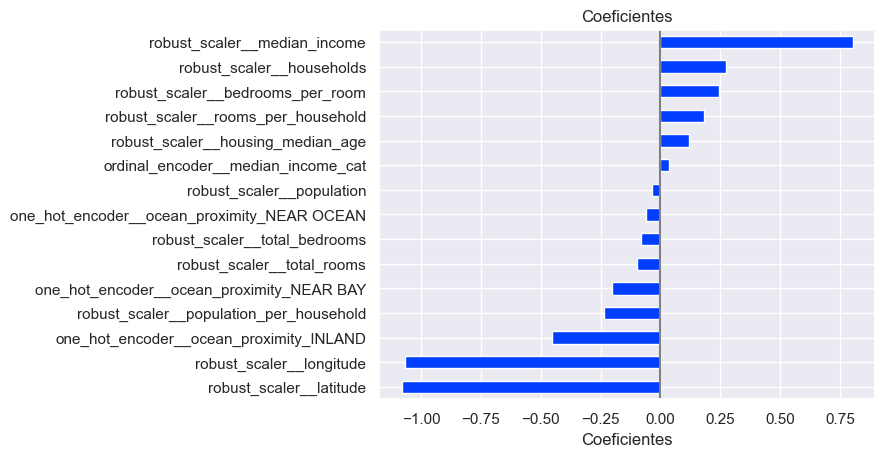

In [43]:
# criando um gráfico com os coeficientes
plot_coeficientes(coefs)

        Por meio do gráfico dos coeficientes, é possível notar que a coluna median_income apresenta uma relação positiva com o target, indicando que o valor das casas tem uma correlação forte com a renda do morador. As colunas longitude e latitude apresentam uma relação negativa muito forte com o target, indicando que há uma correlação forte entre localização das casas e o valor delas. Com isso, os coeficientes mostram que a renda mediana e a localização das casas impactam diretamento no valor das casas, o que parece normal, casas em regiões com rendas maiores, centros comerciais ou próximos de praias costumam ter valores mais elevado, enquanto casas em regiões com baixa renda, mais para o interior, distantes da praia e de centros comerciais têm um valor inferior.

In [49]:
# comparando os processamentos entre os modelos
regressors = {
    "DummyRegressor":{
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    
    "LinearRegression":{
        "preprocessor": preprocessamento_categoricas,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
   
    "LinearRegression_grid_search":{
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

# criando um dicionário com os resultados dos modelos
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

# transformando o dicionário dos resultados em DataFrame
df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.002998,0.003001,-0.000081,-77516.042766,-96239.705692,0.005999
1,DummyRegressor,0.001995,0.002002,-0.000146,-75787.787194,-95217.629397,0.003997
2,DummyRegressor,0.002001,0.001997,-0.001737,-76753.598961,-96253.253947,0.003998
3,DummyRegressor,0.001999,0.002001,-0.000101,-76837.804811,-95983.885799,0.004
4,DummyRegressor,0.000999,0.001999,-0.000114,-76617.245449,-96182.764729,0.002999
5,LinearRegression,0.011002,0.006,0.682162,-39855.690921,-54254.958115,0.017001
6,LinearRegression,0.012997,0.005,0.66999,-40272.565406,-54695.230224,0.017997
7,LinearRegression,0.010001,0.003999,0.649247,-42178.059246,-56955.988686,0.014
8,LinearRegression,0.009008,0.004998,0.669873,-40806.492452,-55146.31876,0.014005
9,LinearRegression,0.010997,0.006,0.669023,-40788.496555,-55331.351171,0.016996


In [55]:
# agrupando por modelo e apresentando a média de cada variável
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.001999,0.0022,-0.000436,-76702.495836,-95975.447913,0.004199
LinearRegression,0.010801,0.005199,0.668059,-40780.260916,-55276.769391,0.016
LinearRegression_grid_search,0.0202,0.0058,0.678107,-38681.963632,-54429.611003,0.026


        Com base na comparação entre as médias das métricas dos modelos, o modelo com grid search apresentou uma melhora no R², MAE e RMSE, apesar de levar um tempo maior para o treinamento, o que é normal devido a validação cruzada entre os pré-processamentos e transformações.

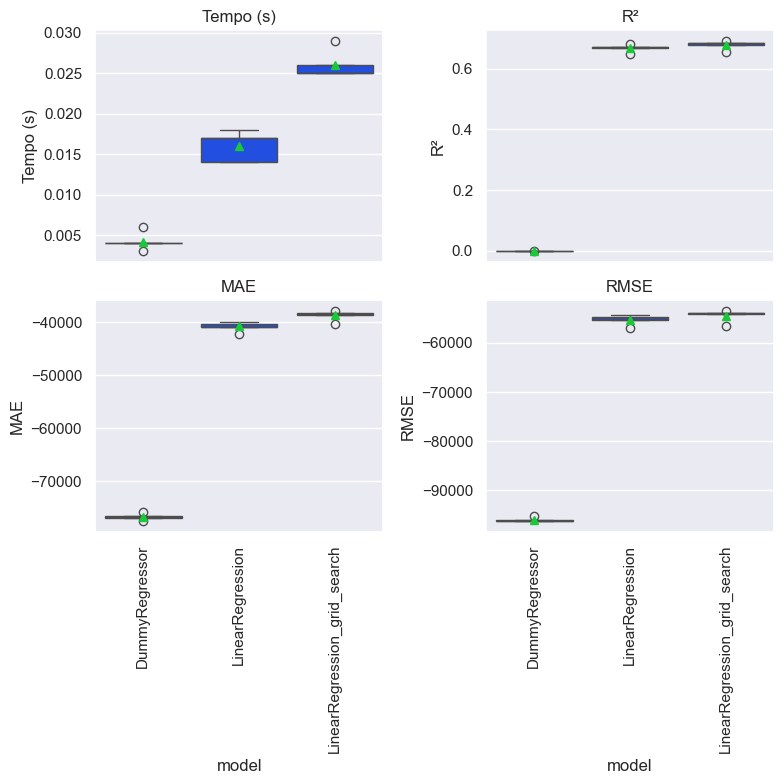

In [57]:
# criando um gráfico com a comparação dos modelos
plot_comparar_metricas_modelos(df_resultados)

        Com base nos boxplots, é possível ver que os coeficientes do modelo com grid search teve um desempenho melhor que o LinearRegression.

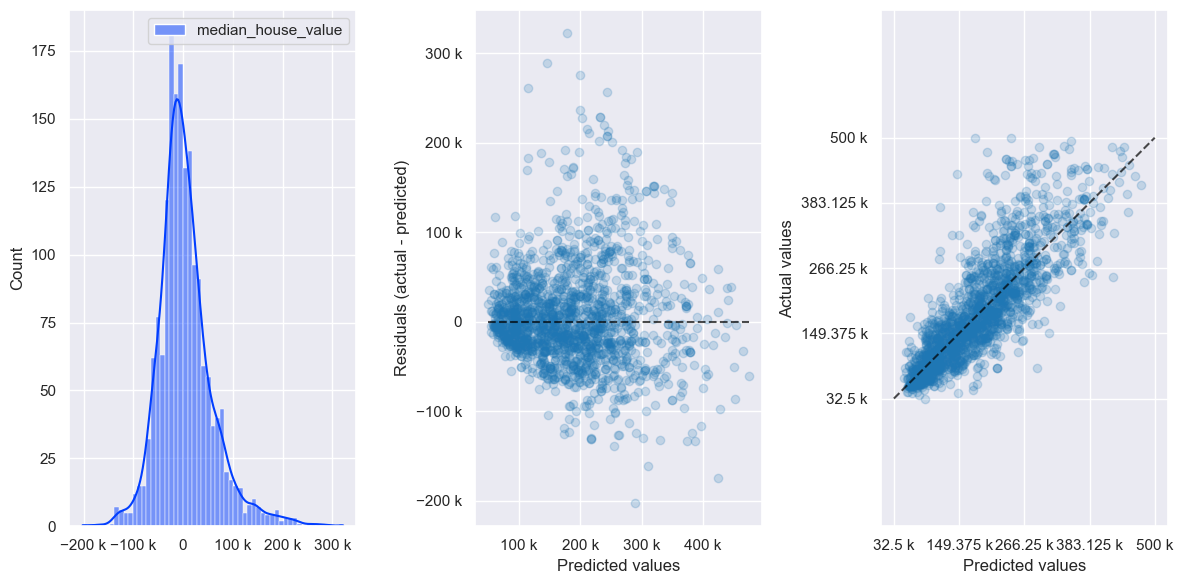

In [59]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

        Nosso modelo continua errando para menos, os valores até 300.000, mesmo assim a maior concentração de pontos está próximo de zero, que é o foco principal.